# CS146 Final Project - Mahjong Statistics Prediction

In [37]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan
import nest_asyncio

# Deal with Python notebook compatability with stan
# See https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
nest_asyncio.apply()

In [38]:
# Import dataset
raw_df = pd.read_csv("./dataset.csv", index_col=[0])
raw_df.head()

,time,rank,score
0,2022/4/17 01:59,1,40400
1,2022/4/17 01:21,2,27300
2,2022/4/17 00:39,3,23500
3,2022/4/16 18:30,2,20300
4,2022/4/16 17:51,4,-300


## Preprocessing

In [39]:
# create copy of df instance
df = raw_df

# Change time column from string to datetime
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,rank,score
0,2022-04-17 01:59:00,1,40400
1,2022-04-17 01:21:00,2,27300
2,2022-04-17 00:39:00,3,23500
3,2022-04-16 18:30:00,2,20300
4,2022-04-16 17:51:00,4,-300


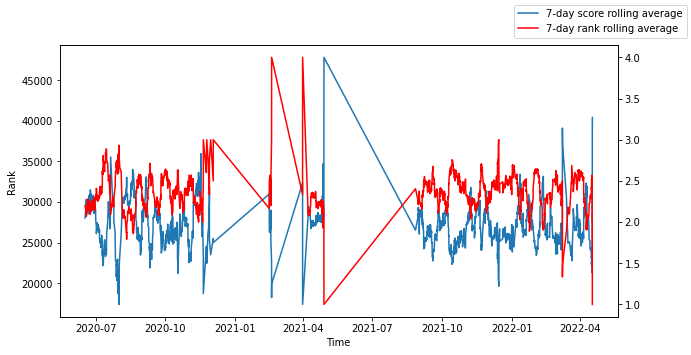

In [40]:
# Calculate weekly averages
df["7d_avg_score"] = df.rolling(window = '7D', on = 'time')['score'].mean()
df["7d_avg_rank"] = df.rolling(window = '7D', on = 'time')['rank'].mean()

# Plot data
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df['time'], df["7d_avg_score"], label = "7-day score rolling average")

ax2 = ax1.twinx()
ax2.plot(df['time'], df["7d_avg_rank"], color= "red",label = "7-day rank rolling average")
ax1.set_xlabel("Time")
ax1.set_ylabel("Score")
ax1.set_ylabel("Rank")
fig.legend()
plt.show()

In [41]:
# Convert time data to timedelta for processing in stan
df['base_time'] = [df['time'].iloc[-1] for _ in range(len(df))]
df['time_delta_min'] = (df['time'] - df['base_time']) / pd.Timedelta(minutes=1)

# Transform data type
df['time_delta_min'] = df['time_delta_min'].astype(int)
df['time_delta_min'].head()

0    963488
1    963450
2    963408
3    963039
4    963000
Name: time_delta_min, dtype: int64

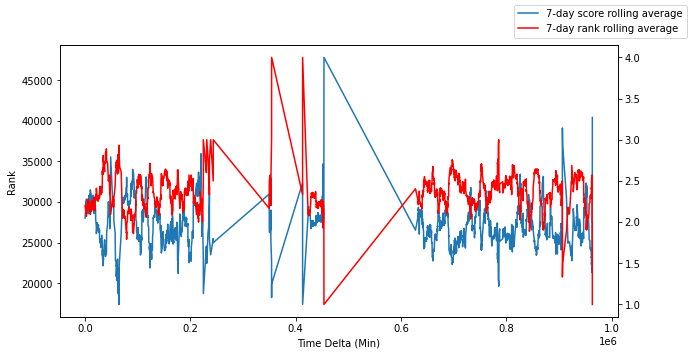

In [42]:
# Plot data
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df['time_delta_min'], df["7d_avg_score"], label = "7-day score rolling average")

ax2 = ax1.twinx()
ax2.plot(df['time_delta_min'], df["7d_avg_rank"], color= "red",label = "7-day rank rolling average")
ax1.set_xlabel("Time Delta (Min)")
ax1.set_ylabel("Score")
ax1.set_ylabel("Rank")
fig.legend()
plt.show()

In [50]:
sum(df['time_delta_min'].isna())

0

In [57]:
# Write model 1
stan_code_1 = """
    data {
        int<lower=1> N;
        vector[N] time;
        vector[N] score;
    }
    parameters {
        real beta;
        real<lower=0> sigma;
    }
    model {
        beta ~ cauchy(0,3);
        sigma ~ normal(10000,100);
        score ~ normal(beta * time, sigma);
    }
    """

In [58]:
# Compile the model
# Put our data in a dictionary
data = {
    'N': len(df), 
    'time': df['time_delta_min'].to_list(), 
    'score': df['7d_avg_score'].to_list()
}

model_1 = stan.build(program_code=stan_code_1, data=data)

Building...

In file included from /Users/enjuichang/Library/Caches/httpstan/4.6.1/models/34cek674/model_34cek674.cpp:2:
In file included from /Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-var

ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-3.7/Users/enjuichang/Library/Caches/httpstan/4.6.1/models/34cek674/model_34cek674.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_64-3.7/Users/enjuichang/Library/Caches/h

In [60]:
# Train the model and generate samples
results_1 = model_1.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3500/8000)
Sampling:  45% (3600/8000

AttributeError: 'Fit' object has no attribute 'extract'

In [61]:
result_summary_1 = results_1.to_frame()
print(result_summary_1.describe().T)

                count          mean           std           min           25%  \
parameters                                                                      
lp__           4000.0 -2.729745e+04  9.545449e-01 -2.730270e+04 -2.729783e+04   
accept_stat__  4000.0  9.369369e-01  9.627110e-02  2.418891e-01  9.194311e-01   
stepsize__     4000.0  1.120229e-01  1.513650e-02  9.777369e-02  9.905180e-02   
treedepth__    4000.0  6.376750e+00  3.381223e+00  1.000000e+00  3.000000e+00   
n_leapfrog__   4000.0  4.673260e+02  4.968197e+02  1.000000e+00  1.500000e+01   
divergent__    4000.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
energy__       4000.0  2.729895e+04  1.541997e+00  2.729653e+04  2.729784e+04   
alpha          4000.0 -9.252012e+07  2.261648e+08 -9.331540e+08 -1.292469e+08   
beta           4000.0  3.812853e-02  3.651340e-04  3.685007e-02  3.788904e-02   
sigma          4000.0  1.139622e+04  7.232565e+01  1.115898e+04  1.134581e+04   

                        50%